#YML: Figure frames#
open X:\Phagocytosis\BCellPhagocytosis\20200729cs1\MontageFrames\cell1_CamB_ch2_stack0023_405nm_0283358msec_0006425951msecAbs_COR_decon.tif;
open X:\Phagocytosis\BCellPhagocytosis\20200729cs1\MontageFrames\cell1_CamA_ch3_stack0023_642nm_0283358msec_0006425951msecAbs_COR_decon.tif;


################# Visualization Settings #################
volume projectionMode 3d;
lighting depthCue false;
material dull;
lighting full;
set bgColor black;

volume #1 region 153,175,0,433,484,307;
#################Images Settings #################
volume #1 style surface step 2 level 57.4 color #ffffff;
volume #2 style surface step 2 level 70;

ui tool show Shell

In [ ]:
from chimerax.color_key import show_key
from chimerax.core import colors
from chimerax.std_commands.wait import wait
from chimerax.surface import vertex_convexity
from chimerax.core.commands import (BoolArg, Bounded, CmdDesc, ColormapArg,
                                    ColormapRangeArg, Int2Arg, IntArg,
                                    SurfacesArg, StringArg, FloatArg, SurfaceArg, AxisArg)
from chimerax.core.commands.cli import EnumOf
from chimerax.map.volumecommand import volume
from chimerax.std_commands.cd import (cd)
from os.path import exists
import numpy
from chimerax.surface.dust import largest_blobs_triangle_mask 
from numpy import (arccos, array, full, inf, isnan, mean, nan, nanmax, nanmean,
                   nanmin, pi, ravel_multi_index, sign, split, sqrt, subtract,
                   count_nonzero, swapaxes, savetxt, column_stack,nansum, nanstd,
                   unique, column_stack, round_, int64, abs, digitize, linspace,
                   zeros, where, delete, shape, ravel, min, shape, isin,flip,
                   ones,asarray)
from scipy.ndimage import (binary_dilation, binary_erosion,
                           generate_binary_structure, iterate_structure, gaussian_filter, gaussian_laplace)
from scipy.spatial import KDTree

from skimage.morphology import (skeletonize,label)
from skimage.feature import canny

from chimerax.map_data import ArrayGridData 
from chimerax.map import volume_from_grid_data

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [ ]:
surface = session.models[1]
to_map = session.models[3]

In [ ]:
def get_image(surface, to_map):
    """Get the isosurface volume mask and secondary channel."""
    mask_vol = surface.volume.full_matrix().copy()
    image_3d = to_map.volume.full_matrix().copy()
    level = surface.volume.maximum_surface_level
    return mask_vol, level, image_3d


def get_coords(image_3d):
    """Get the coords for local intensity"""
    # ChimeraX uses XYZ for image, but numpy uses ZYX, swap dims
    image_3d = swapaxes(image_3d, 0, 2)
    image_coords = array(image_3d.nonzero())
    flattened_image = image_3d.flatten()
    pixel_indices = ravel_multi_index(image_coords, image_3d.shape)
    return image_coords, flattened_image, pixel_indices


def mask_image(mask, level, image_3d):
    """Mask the secondary channel based on the isosurface. Uses a 3D ball to dilate and erode with radius 2, then xor to make membrane mask."""
    mask = mask >= level
    struct_el = iterate_structure(generate_binary_structure(3, 1), 2)
    mask_d = binary_dilation(mask, structure=struct_el)
    mask_e = binary_erosion(mask, structure=struct_el, iterations=2)
    masked = mask_d ^ mask_e
    image_3d *= masked
    return image_3d


def query_tree(init_verts, to_map, radius=inf, knn=200):
    """Create a KDtree from a set of points and query for nearest neighbors.
    index: index of nearest neighbors within radius
    distance: Mean distance of nearest neighbors"""
    tree = KDTree(to_map)
    dist, index = tree.query(init_verts, k=range(
        1, knn), distance_upper_bound=radius, workers=-1)
    dist[dist == inf] = None
    distance = nanmean(dist, axis=1)
    index = array([_index(ind, tree.n) for ind in index], dtype=object)
    return distance, index


def _index(index, tree_max):
    """Tree query pads with tree_max if there are no neighbors."""
    index = index[index < tree_max]
    return index


def local_intensity(flat_img, pixels, index):
    """Measure local mean intensity normalized to mean of all."""
    face_int = array([nanmean(flat_img[pixels[ind]]) for ind in index])
    return face_int/face_int.mean()

radius=15
palette=None
color_range=None
key=False
xnorm=None
ynorm=None
znorm=None 
blob = 1 
output='none'
image_info = get_image(surface, to_map)
masked_image = mask_image(*image_info)
image_coords, *flattened_indices = get_coords(masked_image)
_, index = query_tree(surface.vertices, image_coords.T, radius)
face_intensity = local_intensity(*flattened_indices, index)
surface.intensity = face_intensity



In [ ]:
dust = largest_blobs_triangle_mask(surface.vertices, surface.triangles, surface.triangle_mask, blob_count=1, rank_metric = 'volume rank')

rave = column_stack([(surface.triangles[:,0]*dust),(surface.triangles[:,1]*dust),(surface.triangles[:,2]*dust)]).flatten()

vert_mask = zeros(shape(surface.vertices[:,0]))

vert_mask[rave] = 1
vert_mask3d=column_stack([vert_mask,vert_mask, vert_mask])

t_ver = (surface.vertices * vert_mask3d)
t_ver[t_ver==0] = nan 
centroid = nanmean( t_ver , axis=0)

In [ ]:
thresh = 4

surface.intensity = face_intensity * vert_mask 
intensity_thresh = face_intensity * vert_mask * (face_intensity > thresh)

thresh_mask=(intensity_thresh)

indexvert=where(thresh_mask>0)

masked_Intensity_triangles=delete(surface.triangles,indexvert,axis=0)


In [ ]:
from chimerax.surface import connected_pieces

In [ ]:
blobs=connected_pieces(masked_Intensity_triangles)

Out put of two array [tirangles,vertices] where these are indices

In [ ]:
rty = asarray(blobs[:][:],dtype='int32')
triangleRange = shape(rty)[0]
y=zeros((shape(surface.intensity)[0]))
for n in range(triangleRange):
    vertIndexsingleblob=numpy.ravel(rty[n][0])
    y[vertIndexsingleblob]=1
    

final_mask= y

In [ ]:

measurement = final_mask
palette_string = 'purples'
max_range = 5

In [ ]:

# If all the measurements are np.nan set them to zero.
if isnan(measurement).all():
    measurement[:] = 0

if palette is None:
    palette = colors.BuiltinColormaps[palette_string]

if color_range is not None and color_range != 'full':
    rmin, rmax = color_range
elif color_range == 'full':
    rmin, rmax = nanmin(measurement), nanmax(measurement)
else:
    rmin, rmax = (0, max_range)

In [ ]:
    cmap = palette.rescale_range(rmin, rmax)
    surface.vertex_colors = cmap.interpolated_rgba8(measurement)

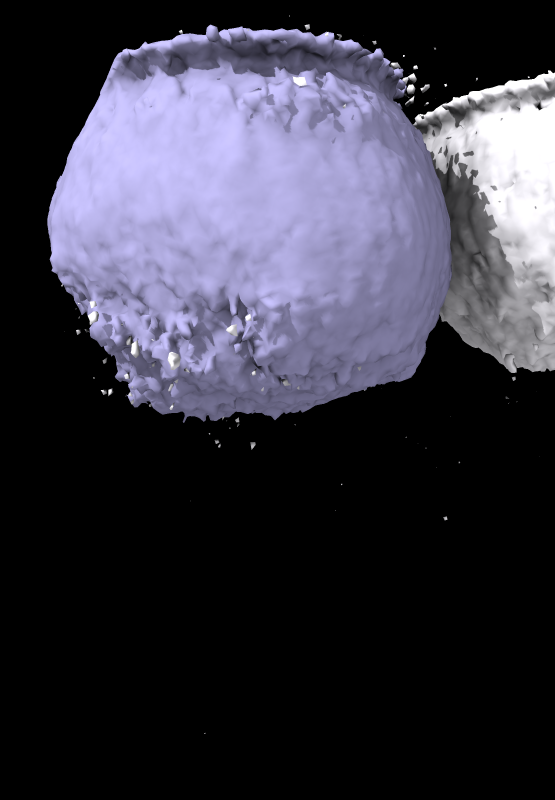

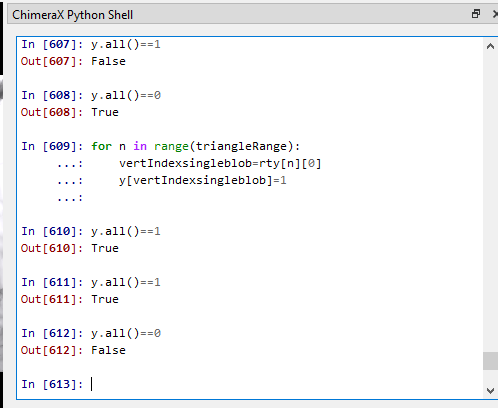


Seems like the series of points sttempted to be sorted to find all "blobs" in the y value matrix is giving all points the same value and isolation of each blob is halted given this. Likely the problem is due to a poor understanding of how to call values from a tuple that has the dtype "object'. Next endevour is to use matplot lib to show case blob geometries and potentially collect the coarse positions for  tracking.

In [ ]:
thresh = 5

surface.intensity = face_intensity * vert_mask 
intensity_thresh = face_intensity * vert_mask * (face_intensity > thresh)

SearchLim = (intensity_thresh>1)

x_coord, y_coord, z_coord = split(surface.vertices, 3, 1)

"""Defining coordinates for surface t"""
x_coord = x_coord.flatten()
y_coord = y_coord.flatten()
z_coord = z_coord.flatten()

size = (1,1,1)
Points = surface.intensity

xx=x_coord[:]*Points
yy=y_coord[:]*Points
zz=z_coord[:]*Points

us=(numpy.max(xx),numpy.max(yy),numpy.max(zz))
dius=max(us)
radius=1+(dius/2)


In [ ]:
def ImgReconstruct(Points, x_coord, y_coord, z_coord, SearchLim, radius, size):
    """This script will reconstruct an image form the location of vertices in your rendered surface"""

    """Logic statments for specific objects we care about"""
    XYZ_SearchR = SearchLim
    XYZ_deletes = where(XYZ_SearchR==0)

    """Solving for unique X,Y,Z coordinates in the search"""
    xx=x_coord[:]*Points
    yy=y_coord[:]*Points
    zz=z_coord[:]*Points

    xyz_raw = column_stack((xx,yy,zz))

    """Reconstruct the image from points we define"""
    xyz=unique(delete(xyz_raw,XYZ_deletes,axis=0),axis=0)

    """Defining the pixel size from human defined parameter"""
    width = size[0]

    """Defining steps that will are approximately one pixel in length"""
    steps = int64(round_(abs((2*radius)/(width))))

    """Indexing the vertices that fall in one pixel of eachother along each axis""" 
    """nearest neighbors approach"""    
    xbins = digitize(xyz[:,0],linspace(-1*(radius),radius,steps))
    ybins = digitize(xyz[:,1],linspace(-1*(radius),radius,steps))
    zbins = digitize(xyz[:,2],linspace(-1*(radius),radius,steps))

    """Making an artificial binary mask of binned vertices into 'pixels' from vertice location"""
    
    ArtImgxyz= zeros([steps,steps,steps])
    ArtImgxyz[xbins,ybins,zbins]= 1

    ArtImg = binary_erosion(((gaussian_filter(ArtImgxyz,.2))>0),border_value=1,iterations=1)
    ArtImg = ArtImg.astype('int8')
    return ArtImg

Attempt halted due to original implimentation of the KD tree assuming both pixel index and size are the same. This results in the inability to generate a artificial image using the previously designed script.

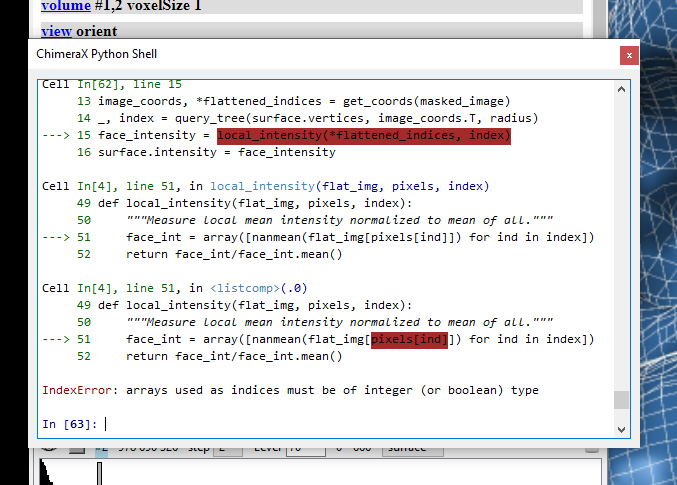

Moving idea back to the original concept

In [ ]:
rty = numpy.ravel(blobs[:][:],order='f')
triangleRange = numpy.int32(shape(rty)[0]/2)
y=zeros((shape(surface.intensity)[0]))
for n in range(triangleRange):
    vertIndexsingleblob=numpy.ravel(rty[n])
    y[vertIndexsingleblob]=1
    

final_mask= y